# **UNet for Crack Segmentation**

In [139]:
path_790 = "/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/labels/Predictions/790_model_nrepochs_200_sig_0-5_complete2.tif"

# To resize to 1024 size

In [140]:
DATA_CLEAN_DIR = "/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/"

#### 790 combine

In [141]:
pred_790_path = os.path.join(DATA_CLEAN_DIR, "data_creation", "data_pipeline", "targets", "2023-09-27-Weimar-Deformation-Epoch7to8-790-128x128-prediction.tif")

In [142]:
good_annotation_790 = Image.open(path_790)
good_annotation_790 = np.array(good_annotation_790, dtype=np.uint8)
bad_annotation_790 = Image.open(pred_790_path)
bad_annotation_790 = np.array(bad_annotation_790, dtype = np.uint8)

In [144]:
new_image = np.zeros((8192, 11264), dtype= np.uint8)
new_image[:2560, :] = good_annotation_790[:2560, :11264]
new_image[2560:, :] = bad_annotation_790[2560:, :11264]

In [145]:
save_path = os.path.join(DATA_CLEAN_DIR, "data_creation", "data_pipeline", "targets", "2023-09-27-Weimar-Deformation-Epoch7to8-790-128x128-prediction-test3.tif")
tiff.imwrite(save_path, new_image)

In [112]:
image = Image.open(path)
print(image.size)
image=np.array(image, dtype=np.uint8)
print(image.shape)
image_new = image[:8192, :11264]
print(image_new.shape)

save_path = os.path.join(DATA_CLEAN_DIR, "data_creation", "data_pipeline", "targets", "2023-09-27-Weimar-Deformation-Epoch7to8-790-128x128-prediction.tif")
tiff.imwrite(save_path, new_image)

(11520, 8704)
(8704, 11520)
(8192, 11264)


# Clean predictions

In [146]:
clean_mask_path = "/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data_creation/data_pipeline/targets/clean_targets/target_for_cleaning.tif"
clean_mask = Image.open(clean_mask_path)
print(clean_mask.size)
clean_mask=np.array(clean_mask, dtype=np.uint8)
print(clean_mask.shape)

(11264, 8192)
(8192, 11264)


In [147]:
epoch = 790

In [148]:
prediction_path = "/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data_creation/data_pipeline/targets/2023-09-27-Weimar-Deformation-Epoch7to8-"+ str(epoch) +"-128x128-prediction.tif"
prediction = Image.open(prediction_path)
print(prediction.size)
prediction=np.array(prediction, dtype=np.uint8)
print(prediction.shape)

(11264, 8192)
(8192, 11264)


In [149]:
prediction[clean_mask == 1] = 0

In [150]:
print(epoch)

790


In [151]:
save_path = os.path.join(DATA_CLEAN_DIR, "data_creation", "data_pipeline", "targets","clean_targets", "2023-09-27-Weimar-Deformation-Epoch7to8-"+ str(epoch) +"-128x128-prediction_clean.tif")
tiff.imwrite(save_path, prediction)

#### Import modules

In [1]:
# For handling .tif files
from PIL import Image
import tifffile as tiff

# For handling the operating system
import os

from glob import glob
from natsort import natsorted
# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# To track training progress
import time

# Torchvision
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms.v2 as transforms
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

# For metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit

# For handling arrays
import numpy as np
import pandas as pd
import math

from importlib import reload

# For plotting
import matplotlib.pyplot as plt
import wandb

import utils
import augmentations
import dataset
import unet
import metrics
import train

reload(utils)
reload(augmentations)
reload(dataset)
#reload(unet) causes problems when instantiating a new model
reload(metrics)
reload(train)

from utils import *
from augmentations import *
from dataset import *
from unet import *
from metrics import *
from train import *

## Create annotated Crack Dataset

#### Parameters

In [2]:
target_size = (256, 256)
SEED = 42
n_classes = 1 # Probability for each pixel to be a crack
target_width=target_size[0]
target_height=target_size[1]

In [3]:
PROJECT_DIR = "/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL"
DATA_PATH = os.path.join(PROJECT_DIR, "data", "data_UNet")

#### Load image

For loading a tif image and splitting it up into patches

In /data/images:
- .tif -> raw experiment images
- .tif.labeling -> annotated raw experiment images from Fiji (Fiji Labeling file)
- _labeling.tif -> Exported Bitmaps from Fiji: **These are to be used to create targets here**
- _transformed.tif -> cropped images which can be overlayed by predicted segmentation mask 

In [66]:
print("Available Images\n")
for _, _, files in os.walk(os.path.join(PROJECT_DIR, "data", "images")):
    for file in files:
        if file.endswith(".tif"):
            if file.split(".")[0][-1].isdigit():
                print(file)

Available Images

2023-09-27-Weimar-Deformation-Epoch7to8-980.tif
2023-09-27-Weimar-Deformation-Epoch7to8-790.tif
2023-09-27-Weimar-Deformation-Epoch7to8-1026.tif
2023-09-27-Weimar-Deformation-Epoch7to8-870.tif


In [38]:
image_name = "2023-09-27-Weimar-Deformation-Epoch7to8-980.tif"
image_path = os.path.join(PROJECT_DIR, "data", "images", image_name)
split_image(image_path, DATA_PATH, target_size)
# for 790 (19.06.24): custom_heightXwidth=[2560,11520]

/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/models/UNet/.venvUNet/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (102060000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


The image 2023-09-27-Weimar-Deformation-Epoch7to8-980.tif is 11664 pixels wide and 8750 pixels high.
Cropped Image width: 11520
Cropped Image height: 8704
Created 1530 images (0 already exist) from 2023-09-27-Weimar-Deformation-Epoch7to8-980.tif
Saved to: /Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/data_UNet/images/2023-09-27-Weimar-Deformation-Epoch7to8-980


#### Load target

For laoding a target tif file and splitting it up into patches

In /data/labels:
- _labeling.tif -> exported Bitmaps from Fiji
    - Workflow in Fiji: Labeling -> Export Selected Label as Bitmap -> name after image with extension _\_labeling_
- Predictions/[image epoch][model name].tif -> Predictions (overlay them with transformed images)
- _transformed_labeling.tif -> annotations on cropped images (cropped to a multitude of 256)
- _transformed_labeling_clean.tif -> annotations on cropped images cleaned of segmentation errors

In [68]:
print("Available Targets\n")
for _, _, files in os.walk(os.path.join(PROJECT_DIR, "data", "labels")):
    for file in files:
        if file.split(".")[0].endswith("_labeling") or file.split(".")[0].endswith("_clean"):
            print(file)

Available Targets

2023-09-27-Weimar-Deformation-Epoch7to8-1026_transformed_labeling.tif
2023-09-27-Weimar-Deformation-Epoch7to8-790_labeling.tif
2023-09-27-Weimar-Deformation-Epoch7to8-870_transformed_labeling.tif
2023-09-27-Weimar-Deformation-Epoch7to8-980_transformed_labeling.tif


In [39]:
target_name = "2023-09-27-Weimar-Deformation-Epoch7to8-980_transformed_labeling.tif"
target_path= os.path.join(PROJECT_DIR, "data", "labels", target_name)
split_target(target_path, DATA_PATH, target_size)
# for 790: custom_heightXwidth=[2560,11520]

The image 2023-09-27-Weimar-Deformation-Epoch7to8-980_transformed_labeling.tif is 11520 pixels wide and 8704 pixels high.
Cropped Target width: 11520
Cropped Target height: 8704


/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/models/UNet/.venvUNet/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (100270080 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Created 1530 images (0 already exist) from 2023-09-27-Weimar-Deformation-Epoch7to8-980_transformed_labeling.tif
Saved to: /Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/data_UNet/targets/2023-09-27-Weimar-Deformation-Epoch7to8-980_transformed_labeling


## Preprocessing

#### Clean the dataset of segmentation errors 

Workflow:
- Scrutinize targets with few pixels --> These are mostly segmentation errors
- Clean targets with a pixel count below a certain threshold (<= 5 is good)
- Scrutinize the targets with few pixels that are left --> these need to be adressed manually
- recreate target from cleaned annotation patches: _labeling_clean.tif
- remove possible segmentation errors manually
- remove previous target patches
- regenerate target patches from cleaned target
- scrutinize targets with few pixels again --> should be correct now

#### Show low pixel targets

In [70]:
# Show targets with few pixels
df, _ = df_for_all_samples(DATA_PATH, testset_size = 0.2, valset_size = 0.2, SEED = SEED)
df_filtered = df[df["num_pixels"] != 0]
top_10 = df_filtered.nsmallest(10, 'num_pixels')
indices_top_10 = top_10.index.tolist()
top_10

,path_image,path_target,crack,num_pixels
3279,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,6
2840,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,7
1681,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,8
2982,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,9
841,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,11
4006,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,11
1385,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,12
4593,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,13
1445,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,14
2938,/Users/saidharb/Documents/LocalDocuments/Studi...,/Users/saidharb/Documents/LocalDocuments/Studi...,1,16


#### Clean targets with few pixels

In [18]:
df, _ = df_for_all_samples(DATA_PATH, testset_size = 0.2, valset_size = 0.2, SEED = SEED)
clean_dataset(df, pixel_threshold = 5)
df, _ = df_for_all_samples(DATA_PATH, testset_size = 0.2, valset_size = 0.2, SEED = SEED)

No annotations with less than 6 pixels in the dataset.


#### Recreate target from cleaned target patches

Only execute if necessary!

Input: Name of the target file path in standard format (epochNumber_transformed_labeling.tif)

In [24]:
target_name = "2023-09-27-Weimar-Deformation-Epoch7to8-980_transformed_labeling.tif"
target_path= os.path.join(PROJECT_DIR, "data", "labels", target_name)
#create_target_from_patches(df, target_path)

#### Split and stratify the dataset

In [4]:
train, val, test = create_splits(DATA_PATH, testset_size = 0.2, valset_size = 0.2, SEED = SEED)

train_images = train["path_image"]
train_images = natsorted(train_images, key=lambda y: y.lower())
train_targets = train["path_target"]
train_targets = natsorted(train_targets, key=lambda y: y.lower())

val_images = val["path_image"]
val_images = natsorted(val_images, key=lambda y: y.lower())
val_targets = val["path_target"]
val_targets = natsorted(val_targets, key=lambda y: y.lower())

test_images = test["path_image"]
test_images = natsorted(test_images, key=lambda y: y.lower())
test_targets = test["path_target"]
test_targets = natsorted(test_targets, key=lambda y: y.lower())

Training
Ratio of crack images to all images: 19.48 %
Ratio of crack pixels to all pixels: 0.38 %
Number of samples: 3024

Validation
Ratio of crack images to all images: 19.54 %
Ratio of crack pixels to all pixels: 0.39 %
Number of samples: 1008

Testing
Ratio of crack images to all images: 19.44 %
Ratio of crack pixels to all pixels: 0.38 %
Number of samples: 1008



In [7]:
print(train_images[1])

/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/data_UNet/images/2023-09-27-Weimar-Deformation-Epoch7to8-790/image_790_0_512.png


#### Data Augmentation

In [12]:
trans = transforms.Compose([
    ToTensor(),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomColorJitter(p=0.5, brightness=0.3, contrast=0.2, saturation=0.2, hue=0.2),
    RandomRotation(p=0.5),
    AddGaussianNoise(p=0.5, mean = 0.0, std = 0.05),
    ElasticTransform(p=0.5,alpha=30, sigma=7),#somehow doesnt work
    ShearTransform(p=0.0, shear_range=(-70, 20)), #introduces a ignore class I think... 
    RandomBlur(p=0.5)])

#### Dataset

In [22]:
crack_dataset=CrackDataset(df["path_image"], df["path_target"], transform = ToTensor())

#### Sanity Check

Check if there are segmentation errors in the annotations that were created with help of the UNet. Sometimes there are predicitons which are only one pixel which are in the majority of the cases segmentation errors, otherwise removing up to five pixels of an edge of a crack seems like a good tradeoff for the time one would have to spend to manually find single pixels in high resolution images.

Number of pixels: 6
target_980_9728_1792.png


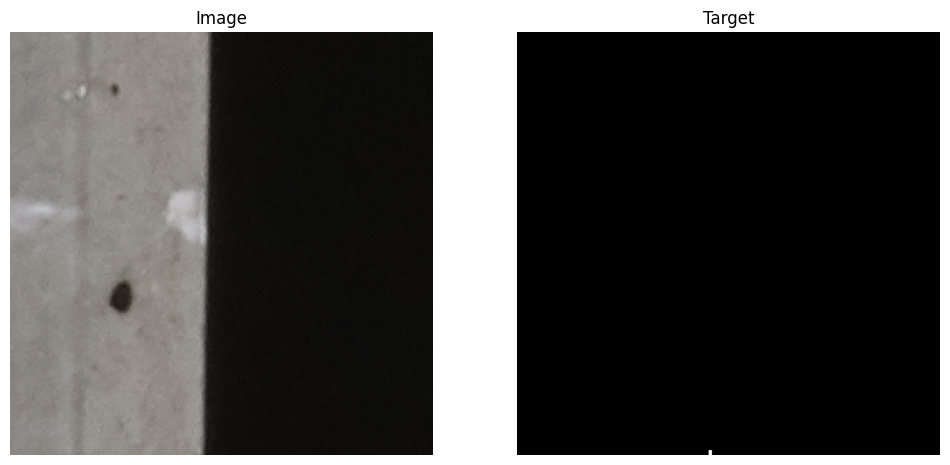

In [55]:
#crack_dataset.visualize(0) #323, 324, 773
for ass in indices_top_10:
    print("Number of pixels: {}".format(top_10["num_pixels"][ass]))
    print(top_10["path_target"][ass].split("/")[-1])
    crack_dataset.visualize(ass) #323, 324, 773
    break

#### Data Loader

In [23]:
dataloader = DataLoader(crack_dataset, batch_size = 1, shuffle = True)
print(len(dataloader))
for batch in dataloader:
    target= batch[1]
    image = batch[0]
    print("\nImage")
    print(type(image))
    print(image.size())
    print(image.dtype)
    print("\nTarget")
    print(type(target))
    print(torch.unique(target))
    print(target.size())
    print(target.dtype)
    break

5040

Image
<class 'torch.Tensor'>
torch.Size([1, 3, 256, 256])
torch.float32

Target
<class 'torch.Tensor'>
tensor([0])
torch.Size([1, 1, 256, 256])
torch.int64


## UNet

Code from: [debuggercafe](https://debuggercafe.com/unet-from-scratch-using-pytorch/)

In [3]:
model = UNet(1)
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

## Training

In [13]:
train_crack_dataset = CrackDataset(train_images, train_targets, transform = trans)
val_crack_dataset = CrackDataset(val_images, val_targets)
test_crack_dataset = CrackDataset(test_images, test_targets)

In [44]:
#model=get_model(train_crack_dataset, val_crack_dataset, num_epochs = 1, train = True, sigmoid_threshold = 0.5, verbose = True)

# TODO

Accomplished:
- ...
- Prediciton mask labeling now possible
- calculation of metrics
- implementation of metrics
- data augmentation
- learning rate decay
- add partly annotated image
- Implement Dice Metric
- generalize code! -> i.e. put into vscode
- Cluster
- visualize contents of csv file
- testing images with Iou and Dice
- adjust data augmentation
- validation and test set
- stratification of dataset
- delete annoatations that are 5 pixels or less -> errors that are hard to detect manually
- recreate the target from cleaned patches
- Implement validation set into training
- Implement saving the best model
- Implement Early Stopping
- make training work again on cluster
- Visualization of training results (wandb)
- Prediction metrics on images
- Evaluation in test set
- finished image 980

**Basically done with the workflow for the UNet model. What's next?**

Next:
- segment new images (finish 790)
- show test results of best UNet model on test set and all images (790, 870, 980, 1026)
- retrain model based on all 4 images
- implement Swin UNETR (should already work somewhere in my directories or collabs)
- accumulate questions for friday




UNet model:

- Segment new images with the use of new model
- automatic test set evaluation for all models
- Automatic prediction of all images by a model for cluster -> pd df


Why Low Training results recently?
- compare with github version from previous commit 68576fc
- why are trainings suddenly so much worse?
    - after looking at github, I changed the batch size from 4 to 16 in one of the last commits
    - there is a heavy class imbalance in my dataset --> is in this case a large batch size disadvantageous?
    - also I removed the Elastic Transform data augmentation after model 135
 
How to improve Training?
- more weight to crack class?

Questions/Ideas

- does it make sense to calculate metrics on images? Or is only the test set relevant?
- dataset is heavily imbalanced --> maybe focal loss better?

## Visualization

#### Visualization of Predictions

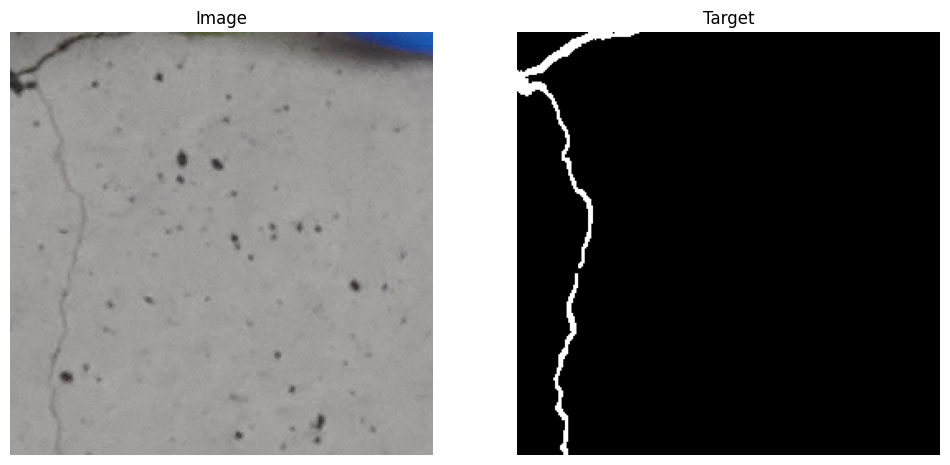

In [27]:
test_crack_dataset.visualize(229)

model_nrepochs_213_sig_0-5.pth


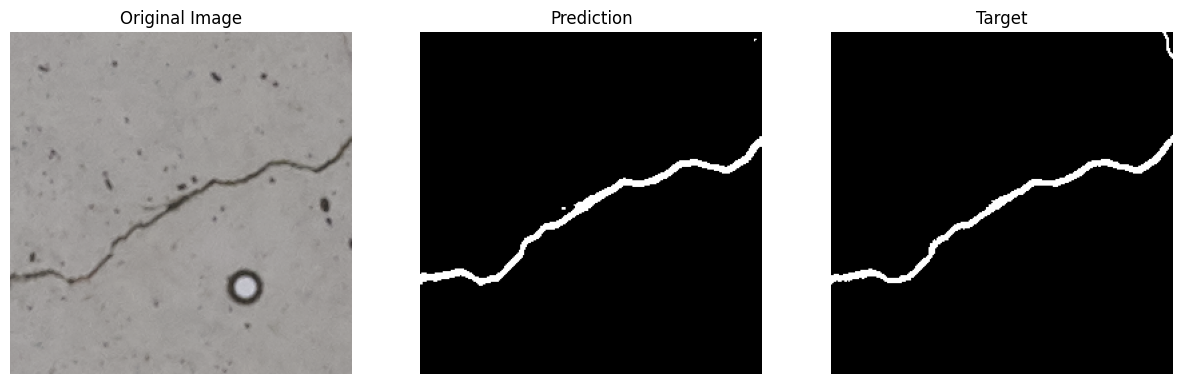

model_nrepochs_100_sig_0-5.pth


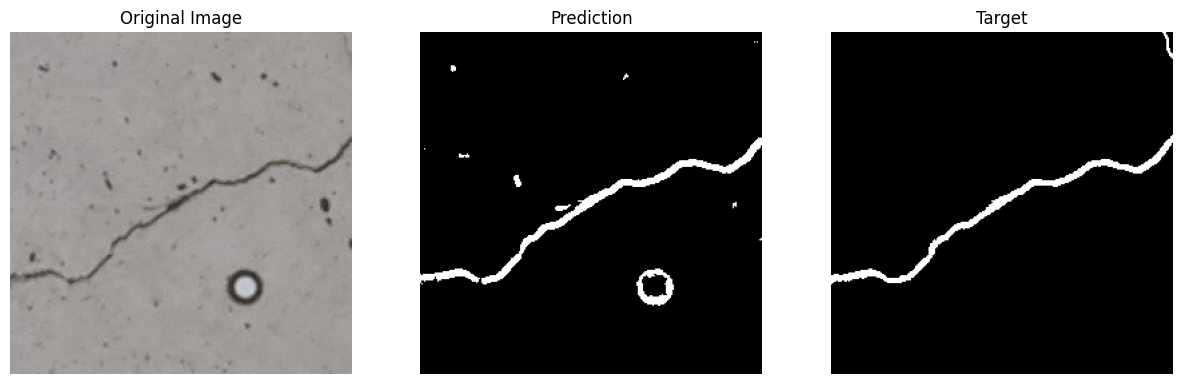

model_nrepochs_139_sig_0-5.pth


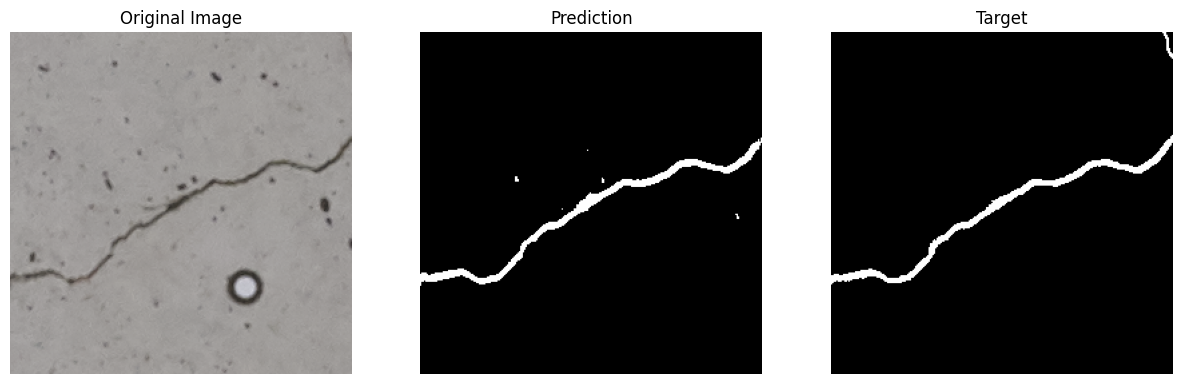

model_nrepochs_64_sig_0-5.pth


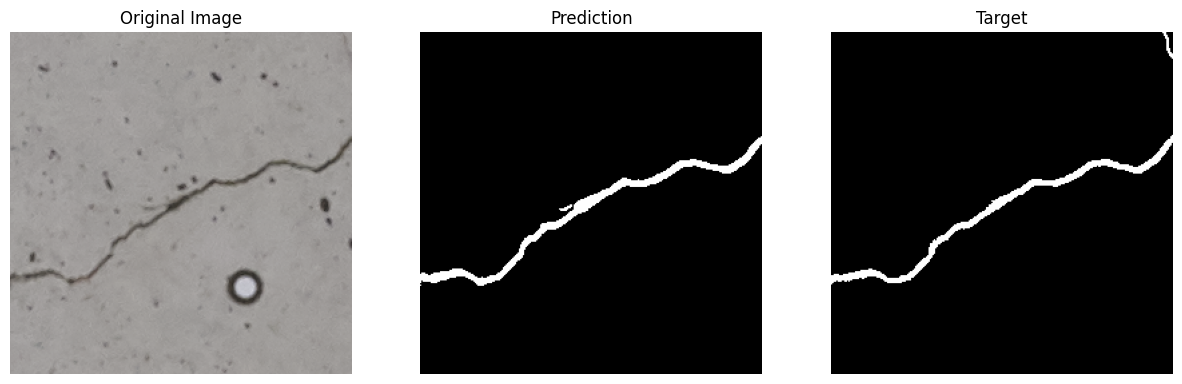

model_nrepochs_200_sig_0-5.pth


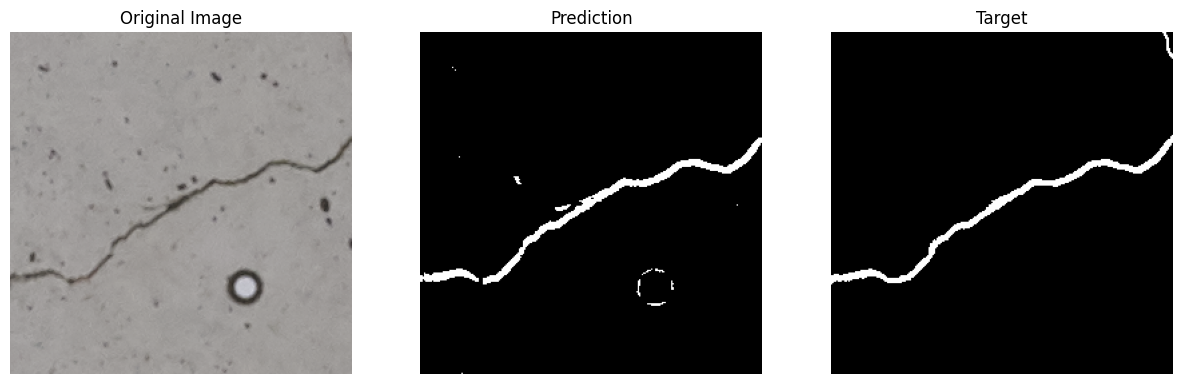

model_nrepochs_135_sig_0-5.pth


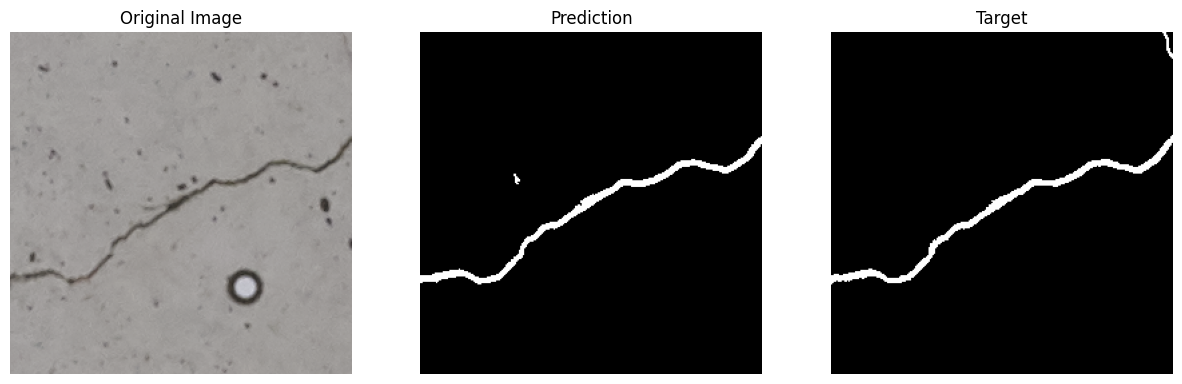

In [30]:
model_dir = os.path.join(PROJECT_DIR, "models", "UNet", "Trained_Models", "Official_Models")
def compare_model_predictions(model_dir, dataset):
    model_paths = glob(os.path.join(model_dir, "**", "*.pth"), recursive=True)
    for model_path in model_paths:
        model = UNet(1)
        checkpoint = torch.load(os.path.join(model_dir, model_path), map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(os.path.basename(model_path))
        visualize_prediction(model, dataset, 230) #229, 230
        plt.show()
compare_model_predictions(model_dir, test_crack_dataset)

#### Visualization of Training Results

In [26]:
csv_file = 'Trained_Models/Official_Models/model_nrepochs_233_sig_0-5_training_logs.csv'
log_wandb("Studienarbeit", "UNet_nrepochs_213_sig_0-5", csv_file)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
time,▇▇██▇█▇▆▇▇▇▇▇▆▇█▇▇█▇▇█▇▇▇█▇▁▁█▁▁▁▁▂▁▂▁▁▁
train background dice,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train background iou,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train crack dice,▁▁▁▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇████████████████
train crack iou,▁▁▁▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
train loss,▇██▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val background dice,▁▁▁▁▃▃▃▅▅▆▅▅▆▆▇▆▇▇▇▇▆▇▇▇█████▇▇█████████
val background iou,▁▁▁▁▃▃▃▅▅▆▅▅▆▆▇▆▇▇▇▇▆▇▇▇█████▇▇█████████
val crack dice,▁▁▁▁▅▆▄▆▆▇▆▆▇▇▇▇█████████████▇██████████


In [35]:
custom_order = ['Val Loss', 
                'Train Crack IoU', 
                'Val Crack IoU', 
                'Train Loss', 
                'Val Loss', 
                'Learning Rate']
csv_file = 'Trained_Models/model_nrepochs_65_sig_0-5_training_logs.csv'
#show_training_results(csv_file, custom_order)

## Model Evaluation

| Model    | Avg. Loss         | Test IOU Crack           | Precision          | Recall             | F1 Score           |
|----------|-------------------|---------------------|--------------------|--------------------|--------------------|
| Model 200| 0.005990963181333923 | 0.5513155569609658 | 0.717204164473724 | 0.7044534894084792 | 0.7107716473120343 |
| Model 64 | 0.004777490495546937 | 0.6124562747288668 | 0.7738926733039485 | 0.7459342226447607 | 0.7596562887658468 |
| Model 100| 0.007247364190292997 | 0.47689205750958713| 0.6465298538572398 | 0.6450815532249918 | 0.645804891541969  |
| Model 139| 0.005005505822706172 | 0.5989263616727695| 0.7694688048108244 | 0.7298969072164948 | 0.749160656837483  |
| Model 135| 0.005394477519509813 | 0.5749633761139258| 0.760656244366034 | 0.7019578715945215 | 0.7301292015216175  |
| Model 213| **0.004421888740508125** | **0.6428830519376884**| **0.7755412808709502** | **0.7898452122760629** | **0.7826278945168298**  |


#### Test Set

In [37]:
model_name = "Model6-213/model_nrepochs_213_sig_0-5.pth"

test_crack_dataset = CrackDataset(test_images, test_targets)
evaluate_test_set(test_crack_dataset, model_name, PROJECT_DIR)

Using device: cpu
1/44
2/44
3/44
4/44
5/44
6/44
7/44
8/44
9/44
10/44
11/44
12/44
13/44
14/44
15/44
16/44
17/44
18/44
19/44
20/44
21/44
22/44
23/44
24/44
25/44
26/44
27/44
28/44
29/44
30/44
31/44
32/44
33/44
34/44
35/44
36/44
37/44
38/44
39/44
40/44
41/44
42/44
43/44
44/44
Testing finished, avg. loss: 0.004421888740508125, test_iou_1: 0.6428830519376884, precision: 0.7755412808709502, recall: 0.7898452122760629, f1_score: 0.7826278945168298


#### Calculate Metrics Epoch 1026

**model_nrepochs_64_sig_0-5**

In [78]:
target_name = "2023-09-27-Weimar-Deformation-Epoch7to8-1026_transformed_labeling.tif"
target_path = os.path.join(PROJECT_DIR, "data", "labels", target_name)

prediction_name = "1026_model_nrepochs_64_sig_0-5.tif"
prediction_path = os.path.join(PROJECT_DIR, "data", "labels", "Predictions", prediction_name)

In [72]:
scores = calculate_metrics(target_path, prediction_path)
scores

/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/models/UNet/.venvUNet/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (100270080 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Duration: 106s


,Precision,Recall,F1-Score,IoU,Dice
Background,0.998202,0.999492,0.998846,0.997696,0.998846
Crack,0.874477,0.662779,0.754051,0.605203,0.754051


**model_nrepochs_200_sig_0-5**

In [75]:
target_name = "2023-09-27-Weimar-Deformation-Epoch7to8-1026_transformed_labeling.tif"
target_path = os.path.join(PROJECT_DIR, "data", "labels", target_name)

prediction_name = "1026_model_nrepochs_200_sig_0-5.tif"
prediction_path = os.path.join(PROJECT_DIR, "data", "labels", "Predictions", prediction_name)

In [76]:
scores = calculate_metrics(target_path, prediction_path)
scores

Duration: 105s


,Precision,Recall,F1-Score,IoU,Dice
Background,0.997769,0.999375,0.998571,0.997147,0.998571
Crack,0.832488,0.581423,0.684665,0.520525,0.684665


#### Reshape original images to match predicted segmentation mask shape
Explanation
>Because the size of the predictions is (256, 256), the resulting predicted segmentation mask has a size of a multiple of 256. This is not true for the original images, which need to be cropped to have a size of a multiple of 256 to overlay the segmentation mask and the image in Fiji later. In this process, only a few non significant pixels on the right side of the image are omitted.```

In /data/images:
- .tif -> raw experiment images
- .tif.labeling -> annotated raw experiment images from Fiji (Fiji Labeling file)
- _labeling.tif -> Exported Bitmaps from Fiji: **These are to be used to create targets here**
- _transformed.tif -> cropped images which can be overlayed by predicted segmentation mask 

In /data/labels:
- _labeling.tif -> exported Bitmaps from Fiji
    - Workflow in Fiji: Labeling -> Export Selected Label as Bitmap -> name after image with extension _\_labeling_
- Predictions/[image epoch][model name].tif -> Predictions (overlay them with transformed images)
- _labeling_transformed.tif -> transformed manual annotations for calculation of metrics

#### Reshape original target to match predicted segmentation mask shape

Explanation: If there are manually annotated targets were created on the original image size. To compare targets and predicted segmentation mask, they need to have matching shapes.

In [23]:
input_target_path = os.path.join(PROJECT_DIR, "data", "labels", image_name + "_labeling.tif")
reshape_data(prediction_path, input_target_path)

Prediction shape: (8704, 11520)
Original Image shape: (8750, 11664)
Transformed Image shape: (8704, 11520)
Saved transformed image tif file to: /Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/labels/2023-09-27-Weimar-Deformation-Epoch7to8-1026_labeling_transformed.tif


## Predict Images
**Workflow**

- Download original .tif file
- Create prediction with best model
- Reshape original image using the prediction to match shapes
- Manually correct the prediction

- Remove all pixel groups that are less than five
- remove all other errors manually

In [40]:
image_name = "2023-09-27-Weimar-Deformation-Epoch7to8-980"
model_name = "model_nrepochs_64_sig_0-5.pth"

In [37]:
predict_image(PROJECT_DIR, image_name, model_name, target_size)

The image 2023-09-27-Weimar-Deformation-Epoch7to8-980.tif is 11664 pixels wide and 8750 pixels high.
Cropped image width: 11520
Cropped image height: 8704
Created 0 images (1530 already exist) from 2023-09-27-Weimar-Deformation-Epoch7to8-980.tif
Saved to: /Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/images/2023-09-27-Weimar-Deformation-Epoch7to8-980_patches


TypeError: super(type, obj): obj must be an instance or subtype of type

In [38]:
def predictt_image(PROJECT_DIR, image_name, model_name, target_size):
    
    #Create patches of non-annotated images
    path_image = os.path.join(PROJECT_DIR, "data", "images", image_name + ".tif")
    image_epoch = image_name.split("-")[-1].split(".")[0]
    DATA_PATH_SEG = os.path.join(PROJECT_DIR, "data", "images")
    create_image_patches(path_image, DATA_PATH_SEG, target_size)

    # Create dataset class for non-annotated image patches
    image_path = os.path.join(PROJECT_DIR, "data", "images", image_name + "_patches")
    image_dataset = ImageDataset(image_path)

    # Create prediction mask for images
    model = UNet(1)
    model_checkpoint = os.path.join(PROJECT_DIR, "models", "UNet", "Trained_Models", "Official_Models", model_name)
    checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model_name = model_name.replace(".pth","")
    save_path = os.path.join(PROJECT_DIR, "data", "labels", "Predictions", image_epoch + "_" + model_name + ".tif")
    seg_mask_pred = create_prediction_mask(model, image_dataset, save_path, threshold = 0.5)


In [39]:
predictt_image(PROJECT_DIR, image_name, model_name, target_size)

/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/models/UNet/.venvUNet/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (102060000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


The image 2023-09-27-Weimar-Deformation-Epoch7to8-980.tif is 11664 pixels wide and 8750 pixels high.
Cropped image width: 11520
Cropped image height: 8704
Created 0 images (1530 already exist) from 2023-09-27-Weimar-Deformation-Epoch7to8-980.tif
Saved to: /Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/images/2023-09-27-Weimar-Deformation-Epoch7to8-980_patches
1530/1530
Duration: 8 minutes
Saved segmentation mask tif file to: /Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/labels/Predictions/980_model_nrepochs_64_sig_0-5.tif


In [42]:
image_epoch = image_name.split("-")[-1].split(".")[0]
save_path = os.path.join(PROJECT_DIR, "data", "labels", "Predictions", image_epoch + "_" + model_name.split(".")[0] + ".tif")
image_name = "2023-09-27-Weimar-Deformation-Epoch7to8-980"
input_image_path = os.path.join(PROJECT_DIR, "data", "images", image_name + ".tif")
prediction_path = save_path

In [43]:
reshape_data(prediction_path, input_image_path)

/Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/models/UNet/.venvUNet/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (100270080 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Prediction shape: (8704, 11520)
Original Image shape: (8750, 11664, 3)
Transformed Image shape: (8704, 11520, 3)
Saved transformed image tif file to: /Users/saidharb/Documents/LocalDocuments/Studienarbeit/Multitemporal-Crack-Segmentation-DL/data/images/2023-09-27-Weimar-Deformation-Epoch7to8-980_transformed.tif


Precision Recall curve to select threshold
Save the best model
Check class imbalance
Train more epochs
Epoch 4 to 5 as validation